In [1]:
import numpy as np
import pandas as pd
from bertopic import BERTopic
from transformers import pipeline, AutoTokenizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import sys
import os
sys.path.append(os.path.abspath(".."))
from process.helpers import text_embedding

f:\Python\Setting\Miniconda\envs\feyy311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate embeddings
The article utilizes the 'all-MiniLM-L12-v2' in sentencetransformers as a light and versatile language model for embeddings. Nevertheless, the model is only able to process less than 512 tokens therefore we created a custom function to cut the text into appropriate paragraphs and return the mean value of embeddings of all the paragraphs.

see: https://sbert.net/

“For transformer models like BERT, RoBERTa, DistilBERT etc., the runtime and memory requirement grows quadratic with the input length. This limits transformers to inputs of certain lengths. A common value for BERT-based models are 512 tokens, which corresponds to about 300-400 words (for English).”

In [2]:
# convert the data into list for the model input
news = pd.read_csv("../data/splited/m_np_ms.csv")
docs = news['content'].astype(str).tolist()

In [3]:
# generate the tokenizer and introduce the model
tokenizer = AutoTokenizer.from_pretrained('../models/all-MiniLM-L12-v2')
embedding_model = SentenceTransformer('../models/all-MiniLM-L12-v2')
max_token = 512

In [4]:
# save the model
embeddings = [text_embedding(doc,tokenizer,embedding_model,max_token) for doc in docs]
embeddings = np.array(embeddings)  # convert into numpy array!
print(type(embeddings),embeddings.shape)
np.save('../data/embs/m_np_ms_emb.npy',embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (1163 > 512). Running this sequence through the model will result in indexing errors
Batches: 100%|██████████| 1/1 [00:00<00:00, 14.54it/s]

<class 'numpy.ndarray'> (146, 384)


# BERTopic model
The BERTopic model selects the umap as the dim-decreasing model and hdbscan as clustering model. First we tested the default values of parameters apart from the 'metric = cosine' as it is well recognized to be more appropriate in the text calculating. Then we fine-tuned some parameters to make the topics more scattered.

In [20]:
# 1. load the local embeddings
embeddings = np.load('../data/embs/m_np_ms_emb.npy')

# 2. create umap model for dim decreasing
umap_model = UMAP(
  n_neighbors=10,
  n_components=5,
  min_dist=0.1,
  metric='cosine',
  random_state= 22 # to avoid stochastic problems
)

'''
    n_neighbors: float (optional, default 15)
        The size of local neighborhood (in terms of number of neighboring
        sample points) used for manifold approximation. Larger values
        result in more global views of the manifold, while smaller
        values result in more local data being preserved. In general
        values should be in the range 2 to 100.

    n_components: int (optional, default 2)
        The dimension of the space to embed into. This defaults to 2 to
        provide easy visualization, but can reasonably be set to any
        integer value in the range 2 to 100.

    metric: string or function (optional, default 'euclidean')
        The metric to use to compute distances in high dimensional space.
        If a string is passed it must match a valid predefined metric. If
        a general metric is required a function that takes two 1d arrays and
        returns a float can be provided. For performance purposes it is
        required that this be a numba jit'd function. Valid string metrics
        include:

        * euclidean
        * manhattan
        * chebyshev
        * minkowski
        * canberra
        * braycurtis
        * mahalanobis
        * wminkowski
        * seuclidean
        * cosine
        * correlation
        * haversine
        * hamming
        * jaccard
        * dice
        * russelrao
        * kulsinski
        * ll_dirichlet
        * hellinger
        * rogerstanimoto
        * sokalmichener
        * sokalsneath
        * yule

        Metrics that take arguments (such as minkowski, mahalanobis etc.)
        can have arguments passed via the metric_kwds dictionary. At this
        time care must be taken and dictionary elements must be ordered
        appropriately; this will hopefully be fixed in the future.
        
     min_dist: float (optional, default 0.1)
        The effective minimum distance between embedded points. Smaller values
        will result in a more clustered/clumped embedding where nearby points
        on the manifold are drawn closer together, while larger values will
        result on a more even dispersal of points. The value should be set
        relative to the ``spread`` value, which determines the scale at which
        embedded points will be spread out.
'''

"\n    n_neighbors: float (optional, default 15)\n        The size of local neighborhood (in terms of number of neighboring\n        sample points) used for manifold approximation. Larger values\n        result in more global views of the manifold, while smaller\n        values result in more local data being preserved. In general\n        values should be in the range 2 to 100.\n\n    n_components: int (optional, default 2)\n        The dimension of the space to embed into. This defaults to 2 to\n        provide easy visualization, but can reasonably be set to any\n        integer value in the range 2 to 100.\n\n    metric: string or function (optional, default 'euclidean')\n        The metric to use to compute distances in high dimensional space.\n        If a string is passed it must match a valid predefined metric. If\n        a general metric is required a function that takes two 1d arrays and\n        returns a float can be provided. For performance purposes it is\n        requir

In [21]:

# 3. create HBBSCAN model for clustering
# to decrease the outliers，fine-tune min_cluster_size  and min_samples
# https://hdbscan.readthedocs.io/en/latest/faq.html
hdbscan_model = HDBSCAN(
  min_cluster_size=3,
  min_samples=3,
  metric='euclidean'
)

'''
  min_cluster_size : int, optional (default=5)
        The minimum size of clusters; single linkage splits that contain
        fewer points than this will be considered points "falling out" of a
        cluster rather than a cluster splitting into two new clusters.

    min_samples : int, optional (default=None)
        The number of samples in a neighborhood for a point to be considered as a core point.
	      This includes the point itself. When None, defaults to min_cluster_size.

    metric : string, or callable, optional (default='euclidean')
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string or callable, it must be one of
        the options allowed by metrics.pairwise.pairwise_distances for its
        metric parameter.
        If metric is "precomputed", X is assumed to be a distance matrix and
        must be square.

'''

'\n  min_cluster_size : int, optional (default=5)\n        The minimum size of clusters; single linkage splits that contain\n        fewer points than this will be considered points "falling out" of a\n        cluster rather than a cluster splitting into two new clusters.\n\n    min_samples : int, optional (default=None)\n        The number of samples in a neighborhood for a point to be considered as a core point.\n\t      This includes the point itself. When None, defaults to min_cluster_size.\n\n    metric : string, or callable, optional (default=\'euclidean\')\n        The metric to use when calculating distance between instances in a\n        feature array. If metric is a string or callable, it must be one of\n        the options allowed by metrics.pairwise.pairwise_distances for its\n        metric parameter.\n        If metric is "precomputed", X is assumed to be a distance matrix and\n        must be square.\n\n'

In [28]:
# 5. add stop words
custom_words =  ['government','nepal','nepali','party','national', 'assembly','jan','april', 'meeting', 'committee', 'minister', 'prime']
stop_words = list(text.ENGLISH_STOP_WORDS.union(custom_words)) 
vectorizer_model = CountVectorizer(stop_words=stop_words) # can only pass list/None/'english'
# vectorizer_model = CountVectorizer(stop_words='english')

# 6. combine the topic model
topic_model = BERTopic(
  embedding_model=embedding_model,
  vectorizer_model=vectorizer_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
)

In [29]:
# 7. inspect the topics
topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,19,-1_nc_police_chief_oli,"[nc, police, chief, oli, climate, general, kat...","[NC, UML reach an understanding not to impleme..."
1,0,28,0_nc_congress_central_krishna,"[nc, congress, central, krishna, president, pr...",[NC CWC meeting being held on Tuesday KATHMAND...
2,1,19,1_hor_parliament_house_peace,"[hor, parliament, house, peace, justice, act, ...",[Bill to amend Political Parties Act tabled in...
3,2,15,2_road_sector_dahal_pm,"[road, sector, dahal, pm, transport, ministry,...",[MoPIT launches major initiatives for road saf...
4,3,15,3_uml_ministers_bhandari_president,"[uml, ministers, bhandari, president, nc, oli,...",[Here is the list of Oli-led Cabinet KATHMANDU...
5,4,15,4_china_foreign_shrestha_visit,"[china, foreign, shrestha, visit, chinese, dep...",[DPM Shrestha calls for Chinese cooperation to...
6,5,11,5_land_maoist_shrestha_martyrs,"[land, maoist, shrestha, martyrs, center, chai...",[Maoist Center Vice-Chair Shrestha demands equ...
7,6,11,6_foreign_ambassador_shrestha_russian,"[foreign, ambassador, shrestha, russian, india...",[Russian envoy calls on Foreign Minister Shres...
8,7,10,7_dahal_president_parliamentary_ipu,"[dahal, president, parliamentary, ipu, chairma...",[Nepali and Chinese parliamentary delegations ...
9,8,3,8_yadav_kumar_raut_jsp,"[yadav, kumar, raut, jsp, justice, chairman, r...",[Senior-most Justice Raut recommended for Chie...


# Visualization

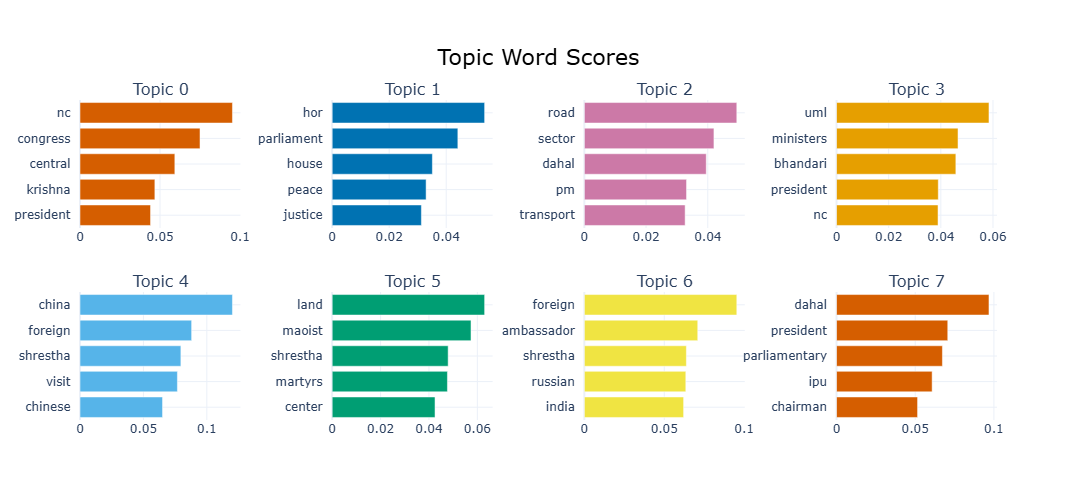

In [30]:
topic_model.visualize_barchart()

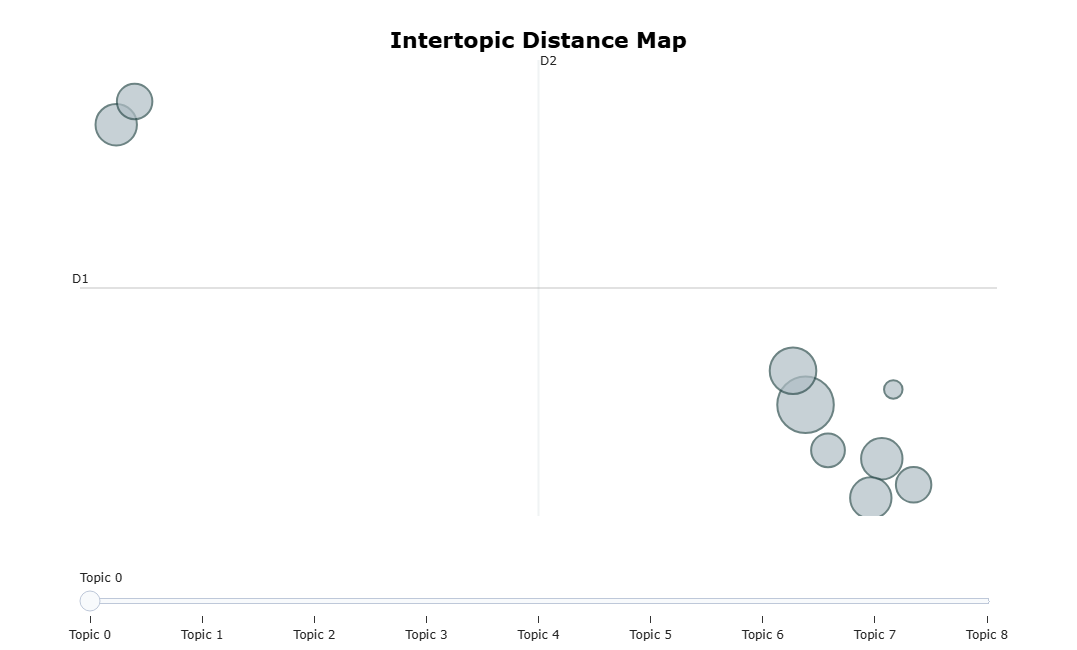

In [31]:
topic_model.visualize_topics()

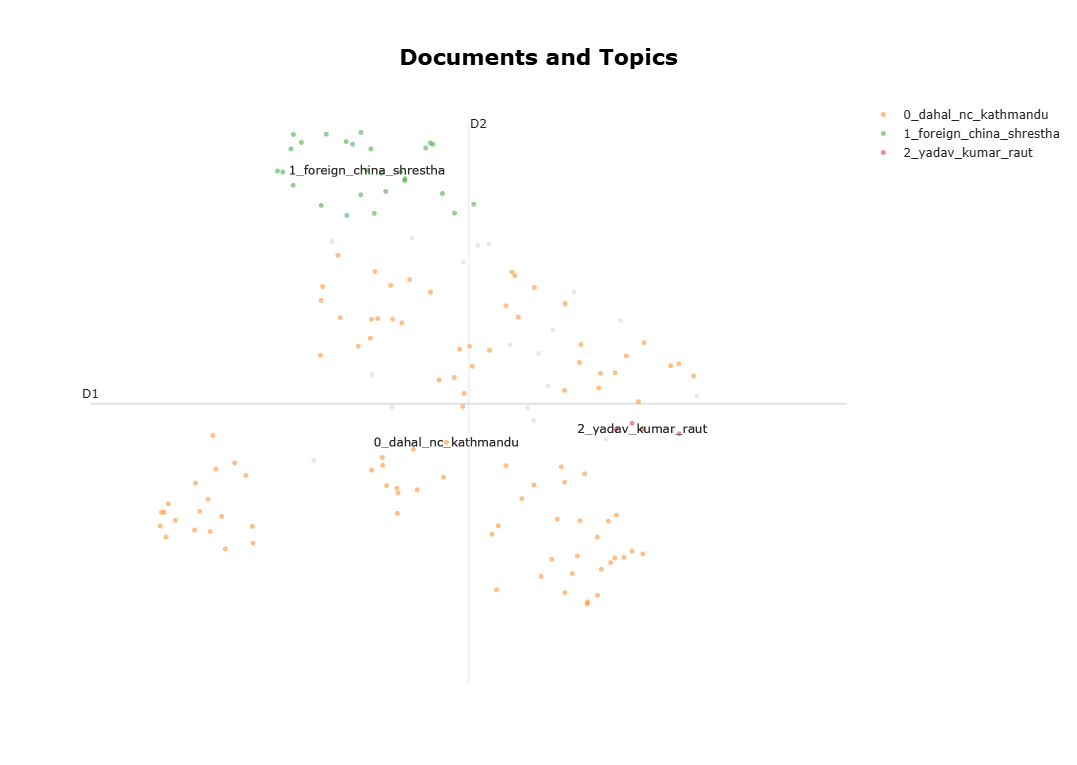

In [39]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.1, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, hide_document_hover=True)

100%|██████████| 8/8 [00:00<00:00, 355.08it/s]


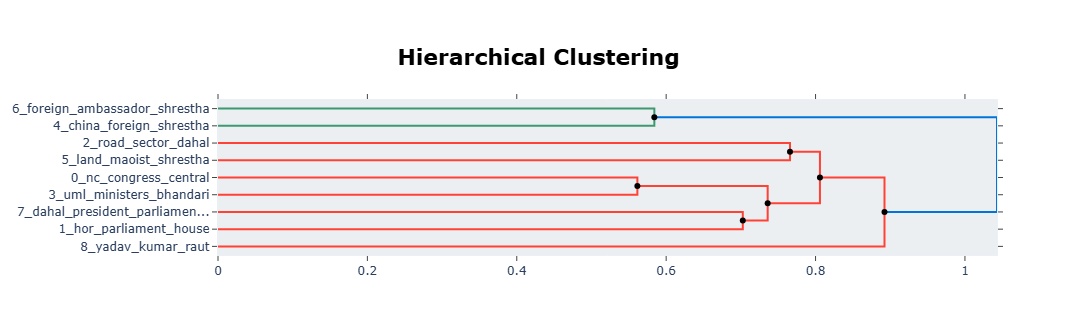

In [33]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [36]:
topic_model.merge_topics(docs, 
[
 [6, 4],
 [2,5,0,3,7,1]
]
)
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,19,-1_nc_police_chief_oli,"[nc, police, chief, oli, kathmandu, climate, g...","[NC, UML reach an understanding not to impleme..."
1,0,98,0_dahal_nc_kathmandu_president,"[dahal, nc, kathmandu, president, chairman, sa...",[PM Dahal reshuffles his cabinet following new...
2,1,26,1_foreign_china_shrestha_visit,"[foreign, china, shrestha, visit, kathmandu, c...",[DPM Shrestha holds consultations with senior ...
3,2,3,2_yadav_kumar_raut_jsp,"[yadav, kumar, raut, jsp, justice, chairman, r...",[Senior-most Justice Raut recommended for Chie...


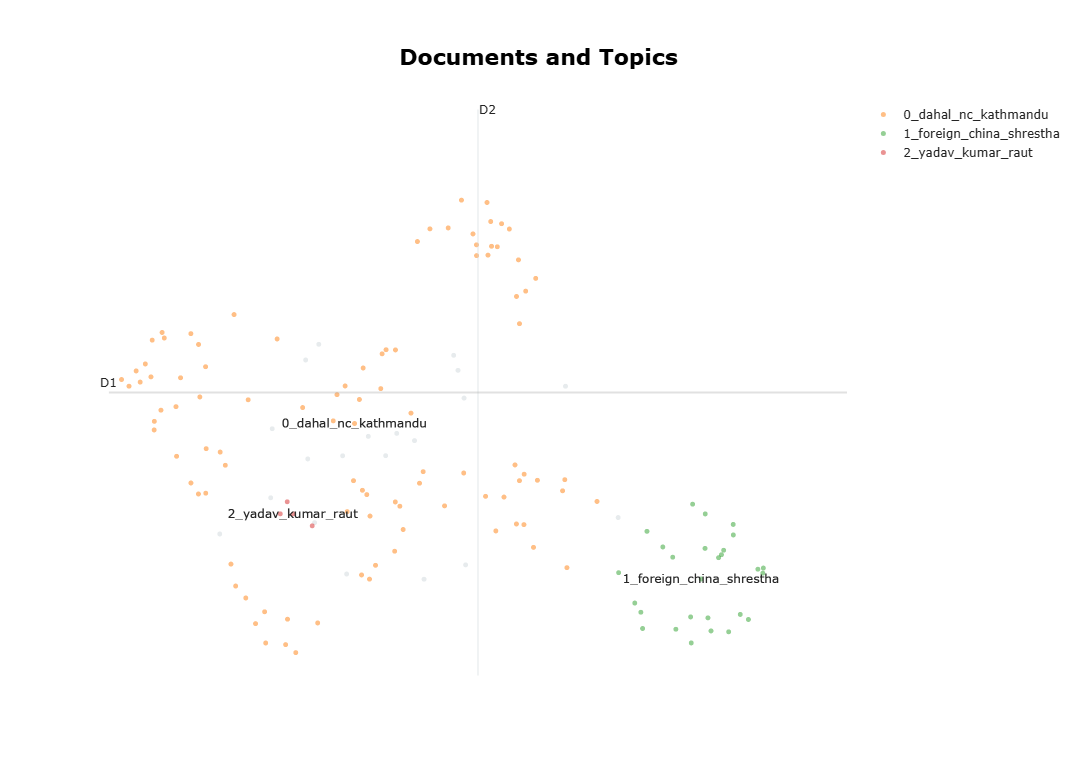

In [40]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.1, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, hide_document_hover=True)

In [38]:
# 8. save the result
topic_docs = topic_model.get_document_info(docs)
topic_docs.to_csv('../data/clusters/cluster_m_np_ms.csv', encoding='utf-8-sig', index=False)